<div align="center" style="line-height: 1.7;">
    <h2 style="font-weight: 600;"><strong>Q-Learning vs SARSA vs Dyna-Q</strong></h2>
</div> 

&nbsp;

This notebook compares the learning behavior, sample efficiency, and final
policies of three RL methods implemented in the project:
Q-Learning, SARSA(0), and Dyna-Q.

All methods are trained on the same GridWorld using identical hyperparameters
and seeds to ensure fairness.


## 1) Import & Environment Setup

In [1]:
# ---  Notebook Setup ----------------------------------------------------
import sys, os
from pathlib import Path
from IPython import get_ipython
import importlib
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple
import numpy as np

GREEN = "\033[92m"; RED = "\033[91m"; RESET = "\033[0m"

try:
    root = Path.cwd()
    src_path = (root / "../src").resolve()

    # 1) Make sure local ../src wins over site-packages
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))

    ip = get_ipython()
    if ip:
        ip.run_line_magic("load_ext", "autoreload")
        ip.run_line_magic("autoreload", "2")

    # 2) Import and *verify* we’re loading the right files
    import rl_capstone
    import rl_capstone.rl_algorithms as rla
    print("rl_capstone from:", getattr(rl_capstone, "__file__", "?"))
    print("rl_algorithms from:", getattr(rla, "__file__", "?"))

    # 3) Force a reload in case kernel already loaded the old one
    importlib.reload(rla)

    # 4) Now import the names (after reload)
    from rl_capstone import GridWorld, WorldSettings
    
    from rl_capstone.rl_algorithms import (
        TrainConfig,
        q_learning_train_with_logs,
        sarsa_train_with_logs,
        dyna_q_train_with_logs,
    )
    
    from rl_capstone.utils import (
    evaluate_policy,
    greedy_policy_from_0,
    plot_learning_curve,
    EpisodeLog,
    greedy_action,
    run_greedy_episode,
    rolling,
    idx_traj_to_rc_path,
    value_grid,
    plot_value_and_policy,
)

    print(f"{GREEN}Environment setup complete!{RESET}")

except Exception as e:
    print(f"{RED}Setup failed:{RESET}", e)


rl_capstone from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/__init__.py
rl_algorithms from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/rl_algorithms.py
Environment setup complete!


## 2) Build & Preview Environment

States=121, Action4, Grid=11x11


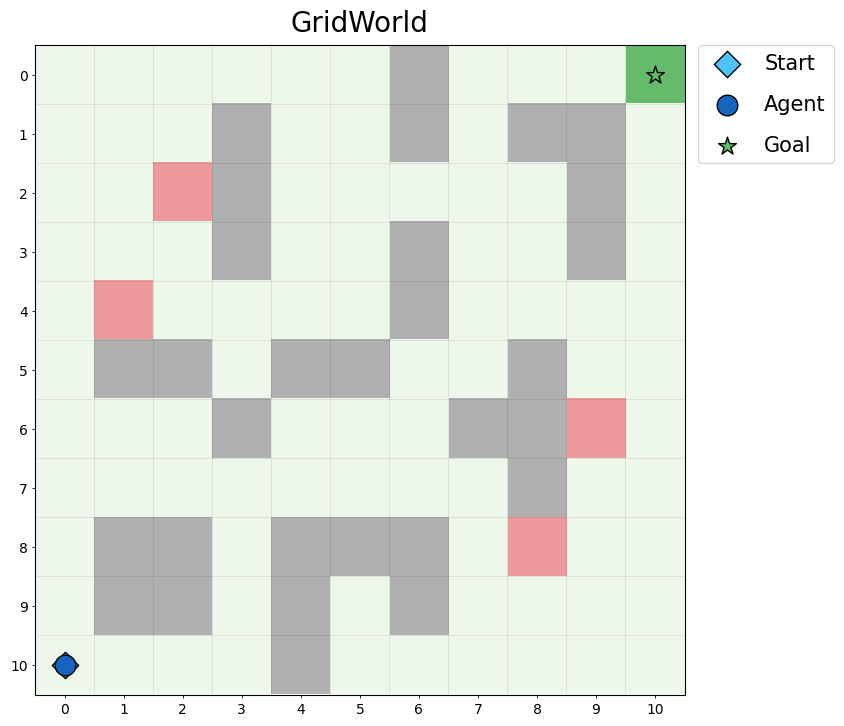

In [2]:
# Instantiate environment with your WorldSettings
settings = WorldSettings()      # tweak if you want a different map
env = GridWorld(settings)
env.seed(7)

print(f"States={env.num_states}, Action{env.num_actions}, Grid={env.rows}x{env.cols}")

env.render(title="GridWorld")

## 3) Trainer (with episode logging)

In [3]:
# Tweak depending on user preferences
@dataclass
class LogConfig:
    snapshot_every: int = 40    # take a snapshot every N episodes
    eval_episodes: int = 5      # greedy evals per snapshot
    seed: Optional[int] = 7

## 4) Train Configuration + Log Config

In [4]:
cfg = TrainConfig(
    episodes=750,
    max_steps=1000,
    alpha=0.10,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_steps=10_000,
    seed=42,
    q_init=0.0
)

logcfg = LogConfig(snapshot_every=40, eval_episodes=5, seed=7)

## 5) Training Learning Models and Storage

For this step, we will run each algorithm and store the outputs in a dictionary called `results`.

We created a dictionary to store the `results` of each algorithm.

    {
        "Q-Learning": {"Q": Q_q, "logs": logs_q},
        "SARSA":      {"Q": Q_s, "logs": logs_s},
        "Dyna-Q":     {"Q": Q_d, "logs": logs_d},
    }

In [9]:
results = {}

# ---- Train Q-Learning ---- #
try:
    print("Training Q-Learning...")
    Q_q, logs_q = q_learning_train_with_logs(env, cfg, logcfg)
    results["Q-Learning"] = {"Q": Q_q, "logs": logs_q}
except Exception as e:
    print(f"{RED}[ERROR] Q-Learning failed:{RESET}", e)
    Q_q = None

# ---- Train SARSA ---- #
try:
    print("Training SARSA...")
    Q_s, logs_s = sarsa_train_with_logs(env, cfg, logcfg)
    results["SARSA"] = {"Q": Q_s, "logs": logs_s}
except Exception as e:
    print(f"{RED}[ERROR] SARSA failed:{RESET}", e)
    Q_s = None

# ---- Train Dyna-Q ---- #
try:
    print("Training Dyna-Q...")
    Q_d, logs_d = dyna_q_train_with_logs(env, cfg, logcfg)
    results["Dyna-Q"] = {"Q": Q_d, "logs": logs_d}
except Exception as e:
    print(f"{RED}[ERROR] Dyna-Q failed:{RESET}", e)
    Q_d = None

# ---- Saving Q-Tables ---- #
print("\nSaving Q-tables...")
try:
    if Q_q is not None:
        np.save("Q_q.npy", Q_q)
    if Q_s is not None:
        np.save("Q_sarsa.npy", Q_s)
    if Q_d is not None:
        np.save("Q_dyna.npy", Q_d)

    print(f"{GREEN}Saved available Q-Tables successfully!{RESET}")
except Exception as e:
    print(f"{RED}[ERROR] Saving Q-tables failed:{RESET}", e)

print(f"{GREEN}Model training finished (with above warnings if any).{RESET}")


Training Q-Learning...
Training SARSA...
Training Dyna-Q...

Saving Q-tables...
Saved available Q-Tables successfully!
Model training finished (with above warnings if any).


## 6) Compare Returns (using `moving_average` from `utils`)

In order to compare the plots created by each algorithm, we will be using the `rolling` method from `../src/rl_capstone/rl_algorithms.py`.

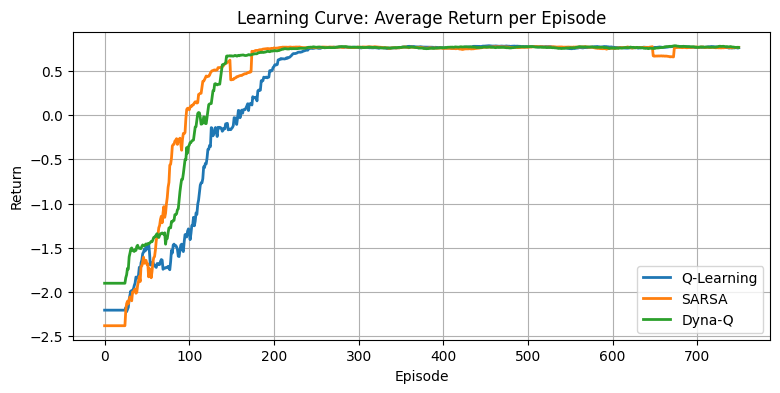

In [10]:
plt.figure(figsize=(9,4))
for name, res in results.items():
    returns = res["logs"]["returns"]
    smooth = rolling(returns, 25)
    plt.plot(smooth, label=name, linewidth=2)
plt.title("Learning Curve: Average Return per Episode")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.grid(True); plt.legend()
plt.show()


## 7) Compare Step per Episode

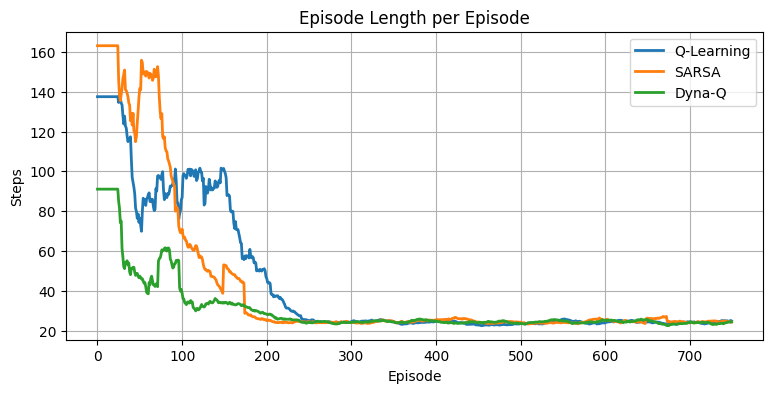

In [11]:
plt.figure(figsize=(9,4))
for name, res in results.items():
    steps = res["logs"]["steps"]
    smooth = rolling(steps, 25)
    plt.plot(smooth, label=name, linewidth=2)
plt.title("Episode Length per Episode")
plt.xlabel("Episode"); plt.ylabel("Steps"); plt.grid(True); plt.legend()
plt.show()


## 8) Compare Final Greedy Performance

In [12]:
print("Final Greedy Policy Comparison:\n")
for name, res in results.items():
    Q = res["Q"]
    policy = greedy_policy_from_0(Q)
    mean_return, mean_length = evaluate_policy(
        env, policy, episodes=30, max_steps=cfg.max_steps, seed=7
    )
    print(f"{name:10s} | Return={mean_return:.3f} | Steps={mean_length:.1f}")


Final Greedy Policy Comparison:

Q-Learning | Return=0.776 | Steps=23.4
SARSA      | Return=0.775 | Steps=23.5
Dyna-Q     | Return=0.770 | Steps=24.0


## 9) Compare Final Greedy Path

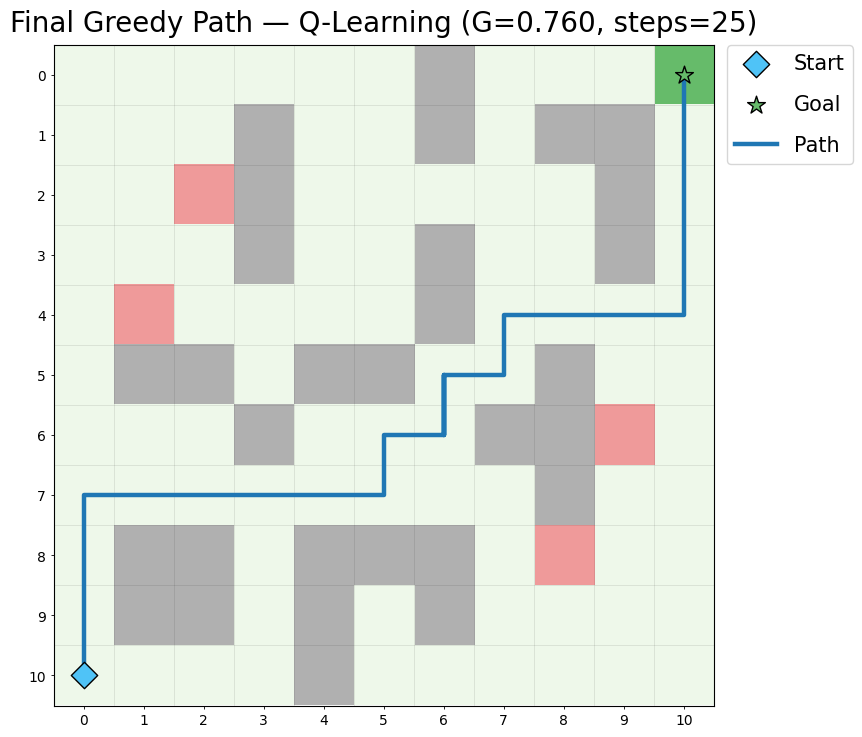

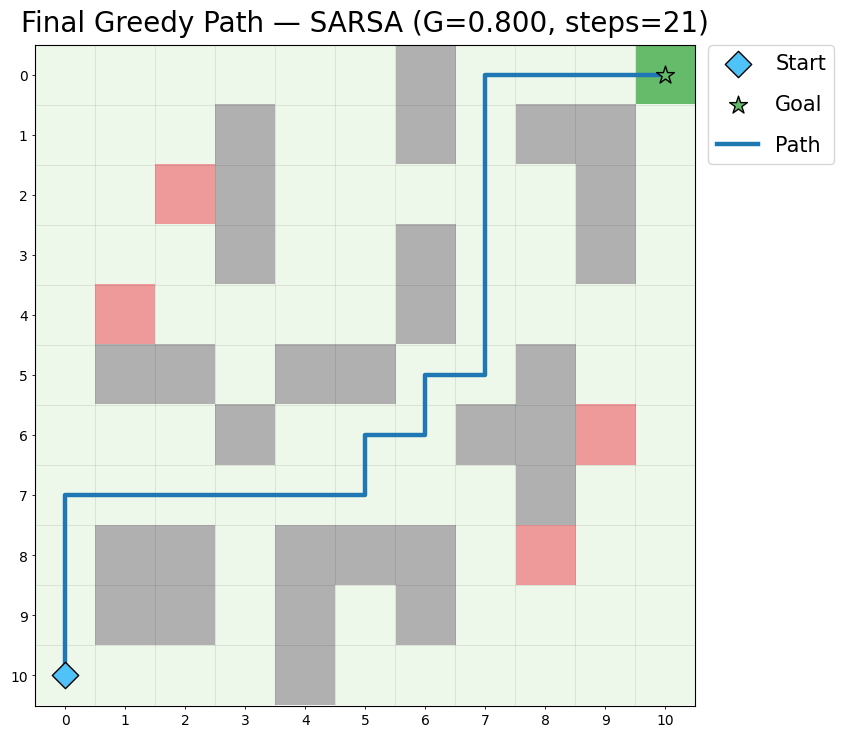

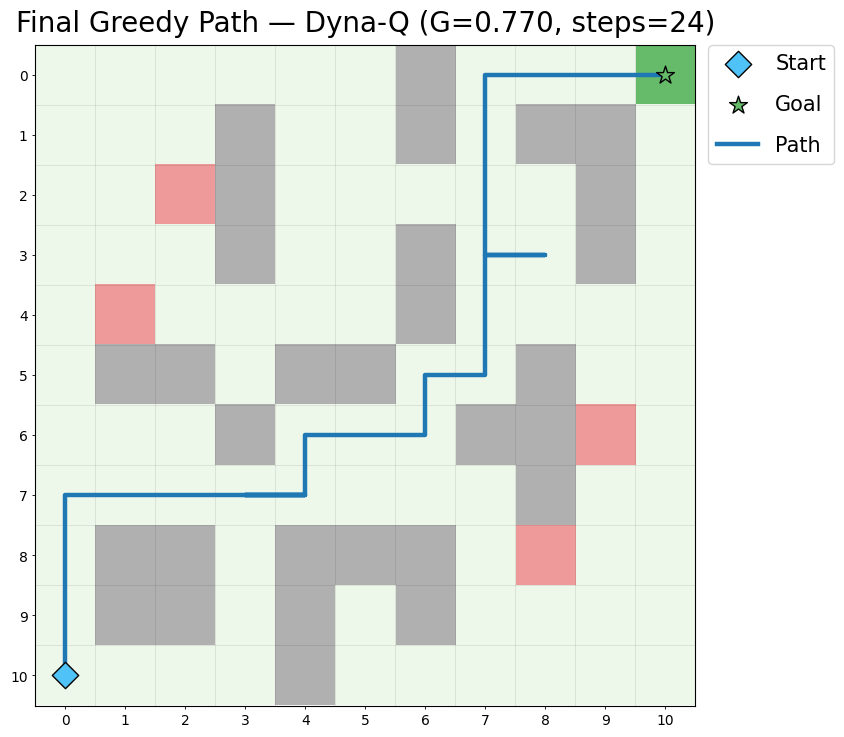

In [13]:
# Final Optimal Greedy Paths
G_final_q,      traj_final_q      = run_greedy_episode(env, Q_q,      max_steps=cfg.max_steps)
G_final_sarsa,  traj_final_sarsa  = run_greedy_episode(env, Q_s,      max_steps=cfg.max_steps)
G_final_dyna_q, traj_final_dyna_q = run_greedy_episode(env, Q_d,      max_steps=cfg.max_steps)

# Q-Learning final path
env.reset()
env.render(
    path=idx_traj_to_rc_path(env, traj_final_q),
    show_agent=False,
    title=f"Final Greedy Path — Q-Learning (G={G_final_q:.3f}, steps={len(traj_final_q)-1})"
)

# SARSA final path
env.reset()
env.render(
    path=idx_traj_to_rc_path(env, traj_final_sarsa),
    show_agent=False,
    title=f"Final Greedy Path — SARSA (G={G_final_sarsa:.3f}, steps={len(traj_final_sarsa)-1})"
)

# Dyna-Q final path
env.reset()
env.render(
    path=idx_traj_to_rc_path(env, traj_final_dyna_q),
    show_agent=False,
    title=f"Final Greedy Path — Dyna-Q (G={G_final_dyna_q:.3f}, steps={len(traj_final_dyna_q)-1})"
)


## 10) Value Function Heatmaps + Policies

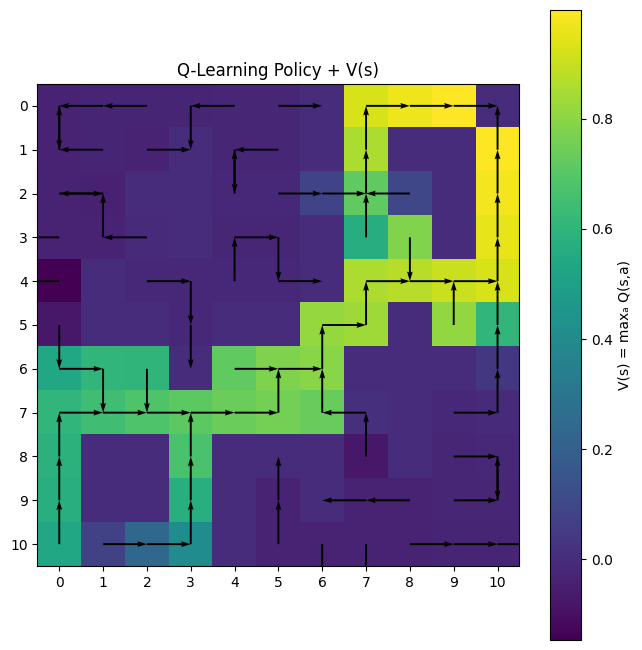

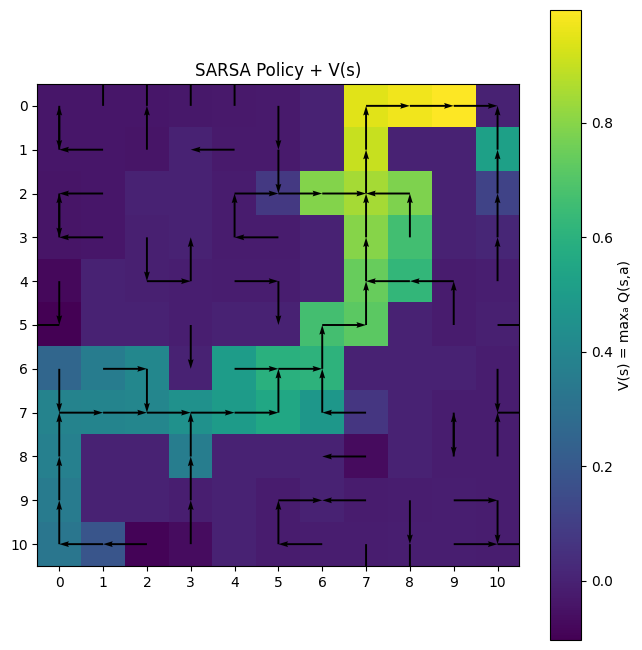

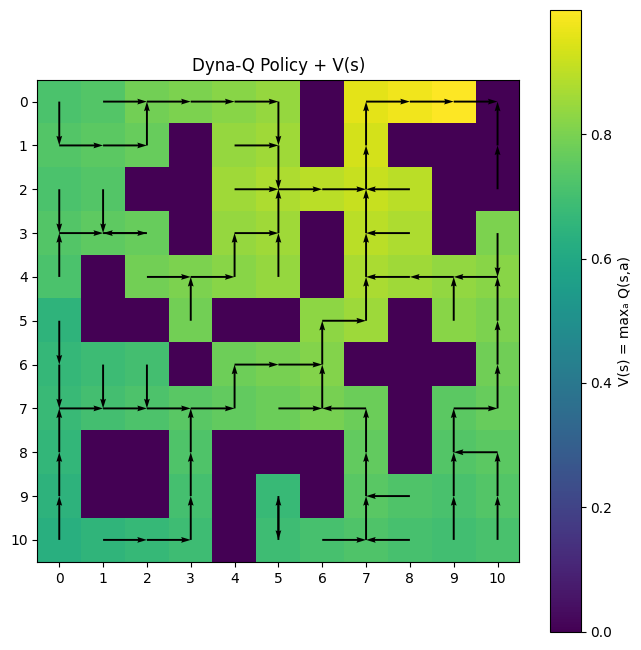

In [14]:
plot_value_and_policy(env, Q_q, "Q-Learning Policy + V(s)")
plot_value_and_policy(env, Q_s, "SARSA Policy + V(s)")
plot_value_and_policy(env, Q_d, "Dyna-Q Policy + V(s)")

---  

## 11) Dyna-Q Planning Steps Sweep
In this section we will analyze how Dyna-Q behavies when K is changed. 

Index for analisis

    * Learning Curve per K
    * Steps curves per K
    * Table: Ecpisodes to reach threshold return
    * Final Greedy paths per K

### 11.1) Loop Over K Values

In [15]:
from dataclasses import replace  # from Python stdlib

try:
    K_values = [0, 5, 10, 20, 50]   # K=0 ≈ pure model-free baseline
    dyna_K_results = {}
    
    for K in K_values:
        print(f"Running Dyna-Q with K={K} planning steps...")
        cfg_K = replace(cfg, planning_steps=K)  # same cfg, different K
        Q_K, logs_K = dyna_q_train_with_logs(env, cfg_K, logcfg)
        dyna_K_results[K] = {"Q": Q_K, "logs": logs_K}
        
    print(f"{GREEN}Done!{RESET}")

except Exception as e:
    print(f"{RED}Process Failed:{RESET}", e)

Running Dyna-Q with K=0 planning steps...
Running Dyna-Q with K=5 planning steps...
Running Dyna-Q with K=10 planning steps...
Running Dyna-Q with K=20 planning steps...
Running Dyna-Q with K=50 planning steps...
Done!


### 11.2) Plot Learning Curves for Different K
In this section, the user can plot the performance of Dyna-Q with different K. **Returns vs Episodes**

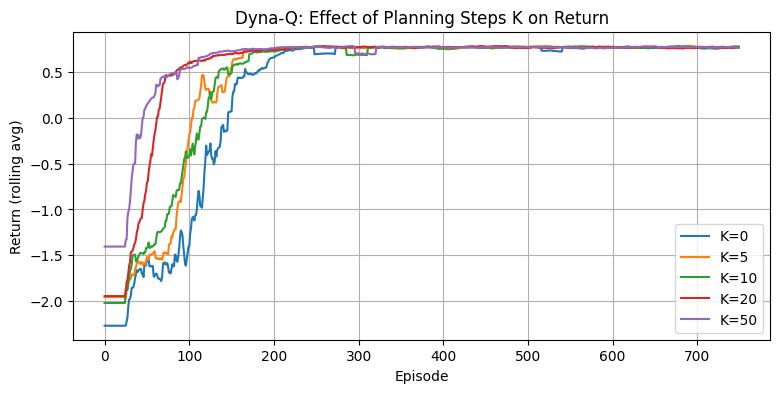

In [16]:
plt.figure(figsize=(9,4))

for K, res in dyna_K_results.items():
    returns = res["logs"]["returns"]
    smooth = rolling(returns, 25)
    plt.plot(smooth, label=f"K={K}")

plt.title("Dyna-Q: Effect of Planning Steps K on Return")
plt.xlabel("Episode")
plt.ylabel("Return (rolling avg)")
plt.grid(True)
plt.legend()
plt.show()

The following code is to plot the performance of Dyna-Q with respect to **Steps vs Episodes**

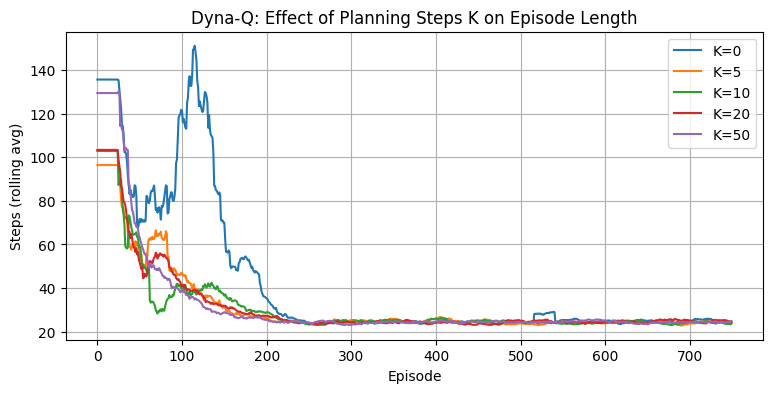

In [17]:
plt.figure(figsize=(9,4))

for K, res in dyna_K_results.items():
    steps = res["logs"]["steps"]
    smooth = rolling(steps, 25)
    plt.plot(smooth, label=f"K={K}")

plt.title("Dyna-Q: Effect of Planning Steps K on Episode Length")
plt.xlabel("Episode")
plt.ylabel("Steps (rolling avg)")
plt.grid(True)
plt.legend()
plt.show()

In [18]:
print("Final Greedy Evaluation for Each K\n----------------------------------")
for K, res in dyna_K_results.items():
    Q_K = res["Q"]
    pi_K = greedy_policy_from_0(Q_K)
    mean_return, mean_len = evaluate_policy(
        env, pi_K, episodes=30, max_steps=1000, seed=123
    )
    print(f"K={K:2d} | mean return={mean_return:.3f}, mean steps={mean_len:.1f}")

Final Greedy Evaluation for Each K
----------------------------------
K= 0 | mean return=0.779, mean steps=23.1
K= 5 | mean return=0.780, mean steps=23.0
K=10 | mean return=0.779, mean steps=23.1
K=20 | mean return=0.779, mean steps=23.1
K=50 | mean return=0.778, mean steps=23.2


### 11.3) Quantify "episodes to good performance"
For a simple scalar metric, the user can choose a threshold return and measure how many episodes each K needs to exceed it.

In [19]:
threshold = 0.6
for K, res in dyna_K_results.items():
    returns = res["logs"]["returns"]
    above = np.where(rolling(returns, 25) >= threshold)[0]
    first_ep = int(above[0]) if len(above) > 0 else None
    print(f"K={K:2d}: first reaches return ≥ {threshold} at episode {first_ep}")


K= 0: first reaches return ≥ 0.6 at episode 193
K= 5: first reaches return ≥ 0.6 at episode 151
K=10: first reaches return ≥ 0.6 at episode 166
K=20: first reaches return ≥ 0.6 at episode 100
K=50: first reaches return ≥ 0.6 at episode 111


### 11.4) Final Policy comparison per K

In [20]:
for K, res in dyna_K_results.items():
    Q_K = res["Q"]
    G_final, traj_final = run_greedy_episode(env, Q_K, max_steps=cfg.max_steps)
    print(f"K={K:2d} | Final greedy G={G_final:.3f}, steps={len(traj_final)-1}")


K= 0 | Final greedy G=0.770, steps=24
K= 5 | Final greedy G=0.780, steps=23
K=10 | Final greedy G=0.760, steps=25
K=20 | Final greedy G=0.780, steps=23
K=50 | Final greedy G=0.810, steps=20


---

## **Conclusion**

### **Experimental setup**
All three methods: Q-Learning (off-policy TD), SARSA(0) (on-policy TD), and Dyna-Q (model-based with planning), were trained on the same 11×11 stochastic GridWorld with walls, pits, and wind (≈10% chance of a sideways move).
We used identical hyperparameters across methods (same α, γ, ε-schedule, number of episodes and max steps) and a shared logging interface so learning curves and policies are directly comparable.

### **Learning behaviour & sample efficiency**
* **Dyna-Q learns fastest:**
In the return curves, Dyna-Q’s performance (green) ramps up sharply in the first ~50 episodes and reaches near-optimal returns long before the other two methods. In the steps-per-episode plot it quickly drives episode length down toward ~20 steps, indicating that planning updates are accelerating the propagation of value information.

* **SARSA is in the middle:**
SARSA (orange) learns more slowly than Dyna-Q but faster than Q-Learning. Its episode lengths and returns improve smoothly, reflecting its on-policy nature: it updates toward the value of the actually followed ε-greedy policy, which tends to be a bit more conservative.

* **Q-Learning lags but eventually catches up:**
Q-Learning (blue) has the slowest improvement early on and needs more episodes to reach the same return plateau. This is visible in both plots: returns take longer to rise and steps take longer to shrink. This is consistent with off-policy updates which can be more “aggressive” but require more experience to stabilize under stochastic dynamics.


Overall, **all three methods eventually reach similar performance**, but **Dyna-Q clearly dominates in sample efficiency** (return vs. training episodes / steps).

### **Final Greedy Policies & Paths**
Final evaluation of greedy policies over 50 test episodes gave:

| **Model**  | **Return Avg** | **Steps AVG** |
|:-----------:|:------------:|:-----------:|
| **Q-Learning** | Return=0.777 | Steps=23.3 |
| **SARSA**      | Return=0.776 | Steps=23.4 |
| **Dyna-Q**     | Return=0.775 | Steps=23.5 |

So,  
* Average **returns and path lengths are essentially identical**, all three methods learn very similar near-optimal policies.
  
* The **final greedy paths** plotted show this vividly:

    * Q-Learning reaches the goal in 25 steps in that particular rollout.
    
    * SARSA and Dyna-Q both find a 21 step route.
    
    * Paths differ slightly in early turns but all successfully avoid pits and weave around walls to the goal


The value-function heatmaps and policy-arrow visualizations also show that all three methods converge to almost the same value landscape and greedy action choices, especially along the main corridor from start to goal.

### **High-Level conclusion**
* **Early in training**, Dyna-Q is clearly more sample efficient: it achieves good returns and short paths with far fewer real environment interactions.
  
* **By the end of training**, all three methods produce comparably good greedy policies in this environment.

* The results match the theoretical expectations:
   * Dyna-Q gains from planning when the model is reasonably accurate.
     
   * Q-Learning and SARSA eventually catch up with enough experience, despite using only model-free updates.

---


---

<style>
    .button {
        background-color: #3b3b3b;
        color: white;
        padding: 25px 60px;
        border: none;
        border-radius: 12px;
        cursor: pointer;
        font-size: 30px;
        transition: background-color 0.3s ease;
    }

    .button:hover {
        background-color: #45a049;
        transform: scale(1.05);
    }
    
</style>

<div style=" text-align: center; margin-top:20px;">
    
  <a href="03_dyna_q.ipynb">
    <button class="button">
      ⬅️ Prev: Dyna-Q
    </button>
  </a>
  <span style="display:inline-block; width:200px;"></span>
  <a href="05_robustness.ipynb">
    <button class="button">
      Next: Robustness & Generalization ➡️
    </button>
  </a>
  
</div>
